In [1]:
print("Hello")

Hello


In [2]:
!pip install lazypredict

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option("display.max_columns",None)
pd.set_option("display.width",500)

In [4]:
df = pd.read_csv("/kaggle/input/football-players/latest_data.csv")

In [5]:
df.head()

,Positioning,Rank,Player Name,OVR,PAC,SHO,PAS,DRİ,DEF,PHY,Position,Acceleration,Sprint Speed,Finishing,Shot Power,Long Shots,Volleys,Penalties,Vision,Crossing,Free Kick Accuracy,Shot Passing,Long Passing,Curve,Agility,Balance,Reactions,Ball Control,Detailed Dribbling,Composure,Interception,Heading Accuracy,Def Awareness,Standing Tackle,Sliding Tackle,Jumping,Stamina,Strength,Aggression,Age,Att_Work_Rate,Def_Work_Rate,Age.1,Foot,Height,League,Nation,Team,Weight
0,93,1,Kylian Mbappé,91,97,90,80,92,36,78,ST,97,97,94,90,83,84,84,83,78,69,86,71,80,93,82,93,92,93,88,38,73,26,34,32,88,88,77,64,24,High,Low,24,Right,18,Ligue 1 Uber Eats,France,Paris SG,75
1,91,2,Alexia Putellas,91,82,90,91,92,72,78,CM,81,82,91,86,89,90,91,91,88,89,94,91,89,90,89,92,94,92,92,78,74,60,81,64,84,85,78,70,29,High,Medium,29,Left,17,Liga F,Spain,FC Barcelona,67
2,96,3,Erling Haaland,91,89,93,66,80,45,88,ST,82,94,96,94,86,90,84,74,47,62,77,53,77,76,72,94,82,79,87,43,83,38,47,29,93,76,93,87,23,High,Medium,23,Left,19,Premier League,Norway,Manchester City,94
3,88,4,Kevin De Bruyne,91,72,88,94,87,65,78,CM,72,72,85,92,92,83,83,95,95,83,94,94,92,74,78,92,92,86,88,66,55,66,70,53,72,88,74,75,32,High,Medium,32,Right,18,Premier League,Belgium,Manchester City,75
4,91,5,Aitana Bonmatí,90,81,84,83,91,75,73,CM,82,80,91,69,89,62,70,90,67,67,91,87,76,93,86,91,91,91,85,88,54,70,81,67,75,80,75,60,25,High,High,25,Right,16,Liga F,Spain,FC Barcelona,51


In [6]:
selected_columns = ["Position", "PAC", "SHO", "PAS", "DRİ", "DEF", "PHY", "OVR","Age","Att_Work_Rate","Def_Work_Rate","Foot","Height","Weight"]
df_new = df[selected_columns]

In [7]:
#Bilgilendirme:
"""
CAM (Central Attacking Midfielder (Merkez Ofansif Orta Saha)) 
CB (Center Back (Stoper))
CDM (Central Defensive Midfielder (Merkez Defansif Orta Saha)
CF(Center Forward (Forvet) - Santrafor) 
CM (Central Midfielder (Merkez Orta Saha)) 
GK (Goalkeeper (Kaleci))
LB ( Left Back (Sol Bek))
LM ( Left Midfielder (Sol Orta Saha))
LW (Left Winger (Sol Kanat)) 
LWB (Left Wing Back (Sol Kanat Bek)) 
RB (Right Back (Sağ Bek))
RM (Right Midfielder (Sağ Orta Saha)) 
RW (Right Winger (Sağ Kanat))
RWB (Right Wing Back (Sağ Kanat Bek))
ST (Striker (Forvet))
----------------------------------------
Oyuncu Rolleri Temelinde Kategorizasyon:

Hücumcu: CF, ST, LW, RW
Orta Saha Oyuncusu: CAM, CDM, CM, LM, RM
Defans Oyuncusu: CB, LB, RB, LWB, RWB
Kaleci: GK

"""

'\nCAM (Central Attacking Midfielder (Merkez Ofansif Orta Saha)) \nCB (Center Back (Stoper))\nCDM (Central Defensive Midfielder (Merkez Defansif Orta Saha)\nCF(Center Forward (Forvet) - Santrafor) \nCM (Central Midfielder (Merkez Orta Saha)) \nGK (Goalkeeper (Kaleci))\nLB ( Left Back (Sol Bek))\nLM ( Left Midfielder (Sol Orta Saha))\nLW (Left Winger (Sol Kanat)) \nLWB (Left Wing Back (Sol Kanat Bek)) \nRB (Right Back (Sağ Bek))\nRM (Right Midfielder (Sağ Orta Saha)) \nRW (Right Winger (Sağ Kanat))\nRWB (Right Wing Back (Sağ Kanat Bek))\nST (Striker (Forvet))\n----------------------------------------\nOyuncu Rolleri Temelinde Kategorizasyon:\n\nHücumcu: CF, ST, LW, RW\nOrta Saha Oyuncusu: CAM, CDM, CM, LM, RM\nDefans Oyuncusu: CB, LB, RB, LWB, RWB\nKaleci: GK\n\n'

# 1. Feature Engineering

In [8]:
# Pozisyonları kategorilere eşleştirmek için bir sözlük oluşturalım
pozisyon_kategori = {
    'Hücum Hattı': ['CF', 'ST', 'LW', 'RW'],
    'Orta Saha': ['CAM', 'CDM', 'CM', 'LM', 'RM'],
    'Defans': ['CB', 'LB', 'RB', 'LWB', 'RWB'],
    'Kale': ['GK']
}

# Yeni bir 'Kategori' sütunu ekleyerek kategorileri atayalım
df_new['Kategori'] = df_new['Position'].apply(lambda x: next((kategori for kategori, pozisyonlar in pozisyon_kategori.items() if x in pozisyonlar), None))

df_new.head()

,Position,PAC,SHO,PAS,DRİ,DEF,PHY,OVR,Age,Att_Work_Rate,Def_Work_Rate,Foot,Height,Weight,Kategori
0,ST,97,90,80,92,36,78,91,24,High,Low,Right,18,75,Hücum Hattı
1,CM,82,90,91,92,72,78,91,29,High,Medium,Left,17,67,Orta Saha
2,ST,89,93,66,80,45,88,91,23,High,Medium,Left,19,94,Hücum Hattı
3,CM,72,88,94,87,65,78,91,32,High,Medium,Right,18,75,Orta Saha
4,CM,81,84,83,91,75,73,90,25,High,High,Right,16,51,Orta Saha


# 2.Encoding

In [9]:
priority_order = ['Low','Medium','High']


def custom_label_encoding(value):
    return priority_order.index(value)


df_new['Att_Work_Rate'] = df_new['Att_Work_Rate'].apply(lambda x: custom_label_encoding(x) if x in priority_order else x)


df_new['Att_Work_Rate'].head(10)

0    2
1    2
2    2
3    2
4    2
5    0
6    2
7    1
8    1
9    2
Name: Att_Work_Rate, dtype: int64

In [10]:
priority_order = ['Low','Medium','High']

def custom_label_encoding(value):
    return priority_order.index(value)

df_new['Def_Work_Rate'] = df_new['Def_Work_Rate'].apply(lambda x: custom_label_encoding(x) if x in priority_order else x)

df_new['Def_Work_Rate'].head()

0    0
1    1
2    1
3    1
4    2
Name: Def_Work_Rate, dtype: int64

In [11]:
label_encoder = LabelEncoder()
df_new['Kategori'] = label_encoder.fit_transform(df_new["Kategori"])
df_new["Kategori"].head(10)

#Bilgilendirme:
"""
Pozisyon Kategori'lerinin Encoding Karşılığı

'Defans': ['CB', 'LB', 'RB', 'LWB', 'RWB'],     = 0
'Hücum Hattı': ['CF', 'ST', 'LW', 'RW'],        = 1
'Kale': ['GK']                                  = 2
'Orta Saha': ['CAM', 'CDM', 'CM', 'LM', 'RM'],  = 3

"""

"\nPozisyon Kategori'lerinin Encoding Karşılığı\n\n'Defans': ['CB', 'LB', 'RB', 'LWB', 'RWB'],     = 0\n'Hücum Hattı': ['CF', 'ST', 'LW', 'RW'],        = 1\n'Kale': ['GK']                                  = 2\n'Orta Saha': ['CAM', 'CDM', 'CM', 'LM', 'RM'],  = 3\n\n"

In [12]:
label_encoder = LabelEncoder()
df_new['Foot'] = label_encoder.fit_transform(df_new["Foot"])
df_new["Foot"].head()

0    1
1    0
2    0
3    1
4    1
Name: Foot, dtype: int64

In [13]:
df_new

,Position,PAC,SHO,PAS,DRİ,DEF,PHY,OVR,Age,Att_Work_Rate,Def_Work_Rate,Foot,Height,Weight,Kategori
0,ST,97,90,80,92,36,78,91,24,2,0,1,18,75,1
1,CM,82,90,91,92,72,78,91,29,2,1,0,17,67,3
2,ST,89,93,66,80,45,88,91,23,2,1,0,19,94,1
3,CM,72,88,94,87,65,78,91,32,2,1,1,18,75,3
4,CM,81,84,83,91,75,73,90,25,2,2,1,16,51,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17321,LB,62,26,34,42,43,57,47,21,2,1,0,17,70,0
17322,CM,61,37,45,48,43,47,47,22,1,1,1,17,66,3
17323,CDM,56,34,43,45,43,51,47,22,1,1,1,18,75,3
17324,CB,58,28,33,39,49,48,47,18,1,1,1,17,70,0


In [14]:
df_new.drop("Position", axis=1, inplace=True)

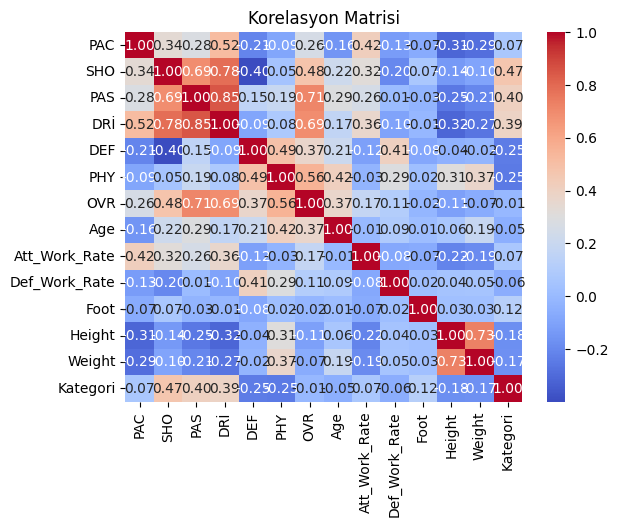

In [15]:
correlation_matrix = df_new.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasyon Matrisi')
plt.show()

# 3.En Doğru Modelin Seçilmesi ve Model Kurma Aşamaları

In [16]:
X = df_new.drop(["Kategori"],axis=1)
y = df_new["Kategori"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# LazyClassifier'ı kullanarak modelleri eğitin
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Modelleri ve tahmin sonuçlarını yazdırın
print(models)

100%|██████████| 29/29 [00:49<00:00,  1.72s/it]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  Time Taken
Model                                                                                   
SVC                                0.86               0.86    None      0.86        3.13
LGBMClassifier                     0.85               0.85    None      0.85        5.61
XGBClassifier                      0.84               0.85    None      0.84        1.20
RandomForestClassifier             0.84               0.84    None      0.84        2.27
ExtraTreesClassifier               0.84               0.84    None      0.84        1.62
BaggingClassifier                  0.82               0.83    None      0.82        0.65
KNeighborsClassifier               0.81               0.82    None      0.80        0.56
LogisticRegression                 0.83               0.82    None      0.83        0.93
CalibratedClassifierCV             0.81               0.79    None      0.81        8.78
LinearDiscriminantAna

# 3.1.SVC İle Modeli Eğitme

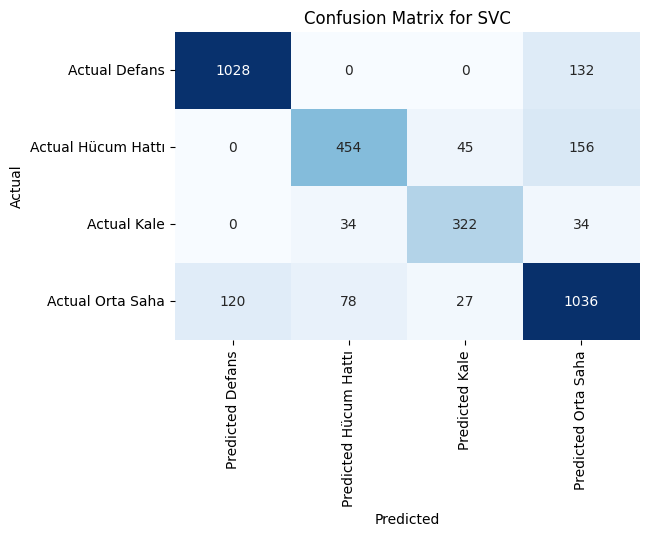

In [19]:
model_svc = SVC()
model_svc.fit(X_train, y_train)
y_pred_svc = model_svc.predict(X_test)

# Confusion matrix oluşturma
cm_svc = confusion_matrix(y_test, y_pred_svc)

# Görselleştirme
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svc, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Defans", "Predicted Hücum Hattı", "Predicted Kale", "Predicted Orta Saha"],
            yticklabels=["Actual Defans", "Actual Hücum Hattı", "Actual Kale", "Actual Orta Saha"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for SVC")
plt.show()


In [20]:
# Sınıf isimleri
class_names = ['Defans', 'Hücum Hattı', 'Kale', 'Orta Saha']

# Classification report'u oluştururken target_names parametresini kullanma
classification_rep_svc = classification_report(y_test, y_pred_svc, target_names=class_names)

# Model performans metrikleri
accuracy_svc = accuracy_score(y_test, y_pred_svc)
precision_svc= precision_score(y_test, y_pred_svc, average='micro')
recall_svc = recall_score(y_test, y_pred_svc, average='micro')
f1_svc= f1_score(y_test, y_pred_svc, average='micro')

model_name_svc = "SVC Model"
print(f'Model Name: {model_name_svc}')
print(f'Model Accuracy: {accuracy_svc}')
print(f'Precision: {precision_svc}')
print(f'Recall: {recall_svc}')
print(f'F1 Score: {f1_svc}')

# Sınıflandırma raporu
print("\nClassification Report:")
print(classification_rep_svc)

Model Name: SVC Model
Model Accuracy: 0.8193883439122909
Precision: 0.8193883439122909
Recall: 0.8193883439122909
F1 Score: 0.819388343912291

Classification Report:
              precision    recall  f1-score   support

      Defans       0.90      0.89      0.89      1160
 Hücum Hattı       0.80      0.69      0.74       655
        Kale       0.82      0.83      0.82       390
   Orta Saha       0.76      0.82      0.79      1261

    accuracy                           0.82      3466
   macro avg       0.82      0.81      0.81      3466
weighted avg       0.82      0.82      0.82      3466



# 3.2.LGBMClassifier İle Modeli Eğitme

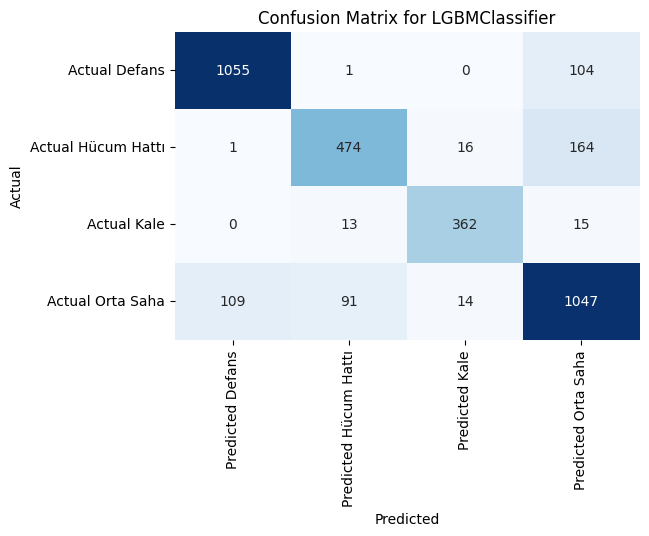

In [21]:
# LGBMClassifier modelini oluşturma
model_lgbm = LGBMClassifier()

# Modeli eğitme
model_lgbm.fit(X_train, y_train)

# Test seti üzerinde tahmin yapma
y_pred_lgbm = model_lgbm.predict(X_test)

# Confusion matrix oluşturma
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

# Görselleştirme
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lgbm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Defans", "Predicted Hücum Hattı", "Predicted Kale", "Predicted Orta Saha"],
            yticklabels=["Actual Defans", "Actual Hücum Hattı", "Actual Kale", "Actual Orta Saha"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for LGBMClassifier")
plt.show()



In [22]:
# Sınıf isimleri
class_names = ['Defans', 'Hücum Hattı', 'Kale', 'Orta Saha']

# Classification report'u oluştururken target_names parametresini kullanma
classification_rep_lgbm = classification_report(y_test, y_pred_lgbm, target_names=class_names)

# Model performans metrikleri
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm, average='micro')
recall_lgbm = recall_score(y_test, y_pred_lgbm, average='micro')
f1_lgbm = f1_score(y_test, y_pred_lgbm, average='micro')

model_name_lgbm = "LGBMClassifier Model"
print(f'Model Name: {model_name_lgbm}')
print(f'Model Accuracy: {accuracy_lgbm}')
print(f'Precision: {precision_lgbm}')
print(f'Recall: {recall_lgbm}')
print(f'F1 Score: {f1_lgbm}')

# Sınıflandırma raporu
print("\nClassification Report:")
print(classification_rep_lgbm)


Model Name: LGBMClassifier Model
Model Accuracy: 0.847663012117715
Precision: 0.847663012117715
Recall: 0.847663012117715
F1 Score: 0.8476630121177149

Classification Report:
              precision    recall  f1-score   support

      Defans       0.91      0.91      0.91      1160
 Hücum Hattı       0.82      0.72      0.77       655
        Kale       0.92      0.93      0.93       390
   Orta Saha       0.79      0.83      0.81      1261

    accuracy                           0.85      3466
   macro avg       0.86      0.85      0.85      3466
weighted avg       0.85      0.85      0.85      3466



# 3.3.XGBClassifier İle  Modeli Eğitme

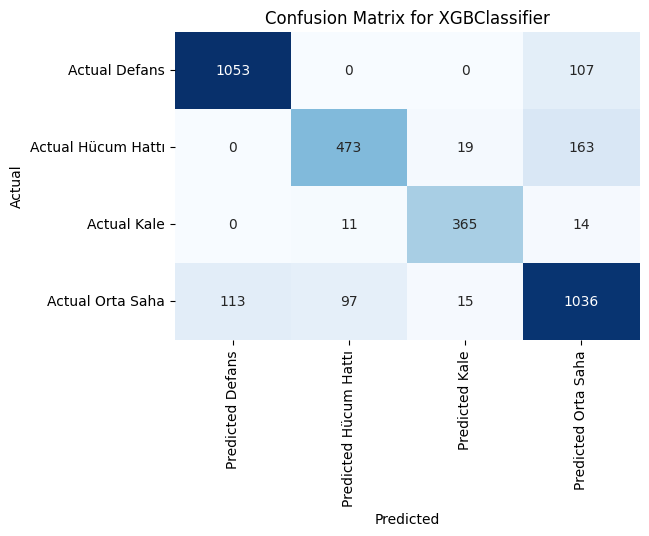

In [23]:
# XGBClassifier modelini oluşturma
model_xgb = XGBClassifier()

# Modeli eğitme
model_xgb.fit(X_train, y_train)

# Test seti üzerinde tahmin yapma
y_pred_xgb = model_xgb.predict(X_test)

# Confusion matrix oluşturma
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Görselleştirme
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Defans", "Predicted Hücum Hattı", "Predicted Kale", "Predicted Orta Saha"],
            yticklabels=["Actual Defans", "Actual Hücum Hattı", "Actual Kale", "Actual Orta Saha"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for XGBClassifier")
plt.show()


In [24]:
# Sınıf isimleri
class_names = ['Defans', 'Hücum Hattı', 'Kale', 'Orta Saha']

# Classification report'u oluştururken target_names parametresini kullanma
classification_rep_xgb = classification_report(y_test, y_pred_xgb, target_names=class_names)

# Model performans metrikleri
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='micro')
recall_xgb = recall_score(y_test, y_pred_xgb, average='micro')
f1_xgb = f1_score(y_test, y_pred_xgb, average='micro')

model_name_xgb = "XGBClassifier Model"
print(f'Model Name: {model_name_xgb}')
print(f'Model Accuracy: {accuracy_xgb}')
print(f'Precision: {precision_xgb}')
print(f'Recall: {recall_xgb}')
print(f'F1 Score: {f1_xgb}')

# Sınıflandırma raporu
print("\nClassification Report:")
print(classification_rep_xgb)

Model Name: XGBClassifier Model
Model Accuracy: 0.8444893248701674
Precision: 0.8444893248701674
Recall: 0.8444893248701674
F1 Score: 0.8444893248701674

Classification Report:
              precision    recall  f1-score   support

      Defans       0.90      0.91      0.91      1160
 Hücum Hattı       0.81      0.72      0.77       655
        Kale       0.91      0.94      0.93       390
   Orta Saha       0.78      0.82      0.80      1261

    accuracy                           0.84      3466
   macro avg       0.85      0.85      0.85      3466
weighted avg       0.84      0.84      0.84      3466



# 3.4.RandomForestClassifier İle Model Eğitme

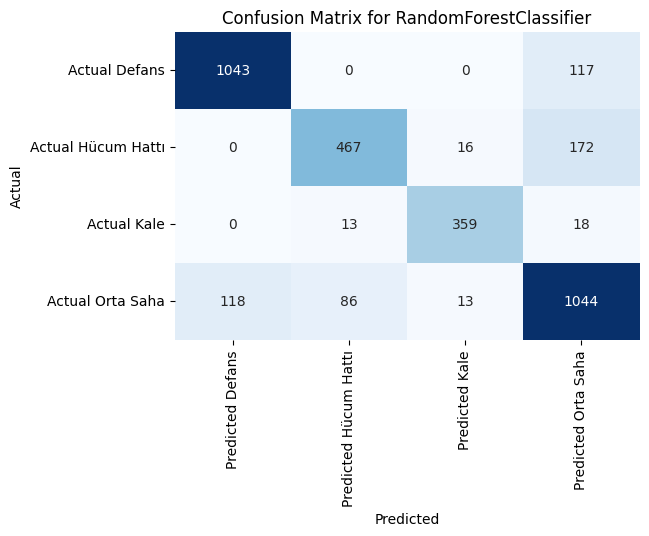

In [25]:
# RandomForestClassifier modelini oluşturma
model_rf = RandomForestClassifier()

# Modeli eğitme
model_rf.fit(X_train, y_train)

# Test seti üzerinde tahmin yapma
y_pred_rf = model_rf.predict(X_test)

# Confusion matrix oluşturma
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Görselleştirme
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Defans", "Predicted Hücum Hattı", "Predicted Kale", "Predicted Orta Saha"],
            yticklabels=["Actual Defans", "Actual Hücum Hattı", "Actual Kale", "Actual Orta Saha"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for RandomForestClassifier")
plt.show()


In [26]:
# Sınıf isimleri
class_names = ['Defans', 'Hücum Hattı', 'Kale', 'Orta Saha']

# Classification report'u oluştururken target_names parametresini kullanma
classification_rep_rf = classification_report(y_test, y_pred_rf, target_names=class_names)

# Model performans metrikleri
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='micro')
recall_rf = recall_score(y_test, y_pred_rf, average='micro')
f1_rf = f1_score(y_test, y_pred_rf, average='micro')

model_name_rf = "RandomForestClassifier Model"
print(f'Model Name: {model_name_rf}')
print(f'Model Accuracy: {accuracy_rf}')
print(f'Precision: {precision_rf}')
print(f'Recall: {recall_rf}')
print(f'F1 Score: {f1_rf}')

# Sınıflandırma raporu
print("\nClassification Report:")
print(classification_rep_rf)

Model Name: RandomForestClassifier Model
Model Accuracy: 0.8404500865551068
Precision: 0.8404500865551068
Recall: 0.8404500865551068
F1 Score: 0.8404500865551068

Classification Report:
              precision    recall  f1-score   support

      Defans       0.90      0.90      0.90      1160
 Hücum Hattı       0.83      0.71      0.76       655
        Kale       0.93      0.92      0.92       390
   Orta Saha       0.77      0.83      0.80      1261

    accuracy                           0.84      3466
   macro avg       0.86      0.84      0.85      3466
weighted avg       0.84      0.84      0.84      3466



# 3.5.Extra Trees Classifier ile  Modeli Eğitme

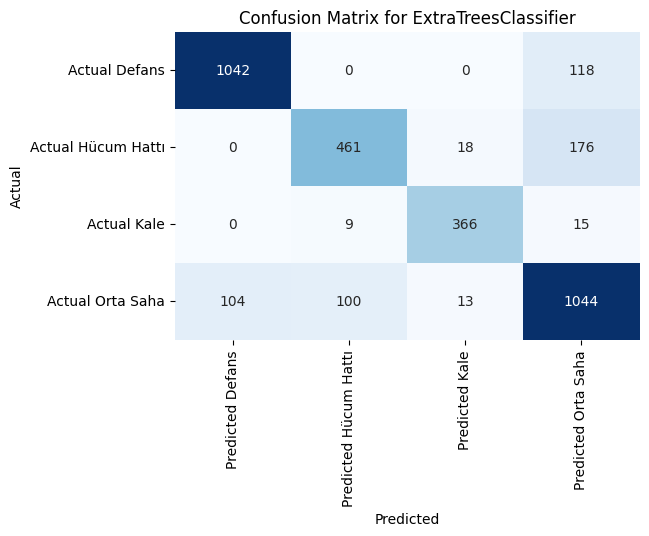

In [27]:
# ExtraTreesClassifier modelini oluşturma
model_et = ExtraTreesClassifier()

# Modeli eğitme
model_et.fit(X_train, y_train)

# Test seti üzerinde tahmin yapma
y_pred_et = model_et.predict(X_test)

# Confusion matrix oluşturma
cm_et = confusion_matrix(y_test, y_pred_et)

# Görselleştirme
plt.figure(figsize=(6, 4))
sns.heatmap(cm_et, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Defans", "Predicted Hücum Hattı", "Predicted Kale", "Predicted Orta Saha"],
            yticklabels=["Actual Defans", "Actual Hücum Hattı", "Actual Kale", "Actual Orta Saha"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for ExtraTreesClassifier")
plt.show()

In [28]:
# Sınıf isimleri
class_names = ['Defans', 'Hücum Hattı', 'Kale', 'Orta Saha']

# Classification report'u oluştururken target_names parametresini kullanma
classification_rep_et = classification_report(y_test, y_pred_et, target_names=class_names)

# Model performans metrikleri
accuracy_et = accuracy_score(y_test, y_pred_et)
precision_et = precision_score(y_test, y_pred_et, average='micro')
recall_et = recall_score(y_test, y_pred_et, average='micro')
f1_et = f1_score(y_test, y_pred_et, average='micro')

model_name_et = "ExtraTreesClassifier Model"
print(f'Model Name: {model_name_et}')
print(f'Model Accuracy: {accuracy_et}')
print(f'Precision: {precision_et}')
print(f'Recall: {recall_et}')
print(f'F1 Score: {f1_et}')

# Sınıflandırma raporu
print("\nClassification Report:")
print(classification_rep_et)

Model Name: ExtraTreesClassifier Model
Model Accuracy: 0.8404500865551068
Precision: 0.8404500865551068
Recall: 0.8404500865551068
F1 Score: 0.8404500865551068

Classification Report:
              precision    recall  f1-score   support

      Defans       0.91      0.90      0.90      1160
 Hücum Hattı       0.81      0.70      0.75       655
        Kale       0.92      0.94      0.93       390
   Orta Saha       0.77      0.83      0.80      1261

    accuracy                           0.84      3466
   macro avg       0.85      0.84      0.85      3466
weighted avg       0.84      0.84      0.84      3466



# 3.6.Logistic Regression İle Modeli Eğitme

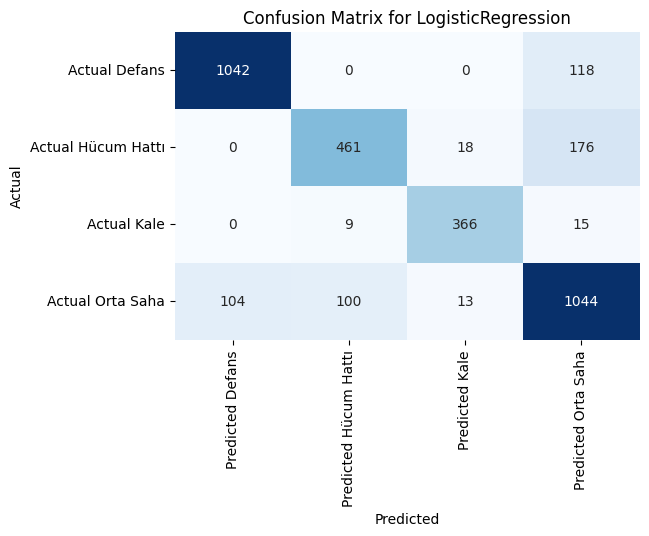

In [29]:
# ExtraTreesClassifier modelini oluşturma
model_log = LogisticRegression()

# Modeli eğitme
model_log.fit(X_train, y_train)

# Test seti üzerinde tahmin yapma
y_pred_log = model_log.predict(X_test)

# Confusion matrix oluşturma
cm_log = confusion_matrix(y_test, y_pred_et)

# Görselleştirme
plt.figure(figsize=(6, 4))
sns.heatmap(cm_et, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Defans", "Predicted Hücum Hattı", "Predicted Kale", "Predicted Orta Saha"],
            yticklabels=["Actual Defans", "Actual Hücum Hattı", "Actual Kale", "Actual Orta Saha"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for LogisticRegression")
plt.show()

In [30]:
# Sınıf isimleri
class_names = ['Defans', 'Hücum Hattı', 'Kale', 'Orta Saha']

# Classification report'u oluştururken target_names parametresini kullanma
classification_rep_log = classification_report(y_test, y_pred_log, target_names=class_names)

# Model performans metrikleri
accuracy_log = accuracy_score(y_test, y_pred_log)
precision_log = precision_score(y_test, y_pred_log, average='micro')
recall_log = recall_score(y_test, y_pred_log, average='micro')
f1_log = f1_score(y_test, y_pred_log, average='micro')

model_name_log = "Logistic Regression Model"
print(f'Model Name: {model_name_log}')
print(f'Model Accuracy: {accuracy_log}')
print(f'Precision: {precision_log}')
print(f'Recall: {recall_log}')
print(f'F1 Score: {f1_log}')

# Sınıflandırma raporu
print("\nClassification Report:")
print(classification_rep_log)

Model Name: Logistic Regression Model
Model Accuracy: 0.7899596076168494
Precision: 0.7899596076168494
Recall: 0.7899596076168494
F1 Score: 0.7899596076168494

Classification Report:
              precision    recall  f1-score   support

      Defans       0.89      0.88      0.89      1160
 Hücum Hattı       0.75      0.71      0.73       655
        Kale       0.73      0.67      0.70       390
   Orta Saha       0.74      0.78      0.76      1261

    accuracy                           0.79      3466
   macro avg       0.78      0.76      0.77      3466
weighted avg       0.79      0.79      0.79      3466



# 4.Raporların DataFrameinin Oluşturulması ve .csv Dosyası Olarak Kaydedilmesi

## 4.1.SVC Raporu Kaydetne

In [31]:
# Classification report'u oluştururken target_names parametresini kullanma
classification_rep_svc = classification_report(y_test, y_pred_svc, target_names=class_names, output_dict=True)

# Sınıflandırma raporunu DataFrame'e dönüştürme
classification_df_svc = pd.DataFrame(classification_rep_svc).transpose()

# Model performans metriklerini DataFrame'e ekleme
metrics_df_svc = pd.DataFrame({
    'Model Name': [model_name_svc],
    'Model Accuracy': [accuracy_svc],
    'Precision': [precision_svc],
    'Recall': [recall_svc],
    'F1 Score': [f1_svc]
})

# DataFrame'leri birleştirme
result_df_svc = pd.concat([metrics_df_svc, classification_df_svc], axis=1)

# CSV dosyasına kaydetme
result_df_svc.to_csv('classification_results_svc.csv', index=False)

# Oluşturulan DataFrame'i gösterme
print(result_df_svc)

             Model Name  Model Accuracy  Precision  Recall  F1 Score  precision  recall  f1-score  support
0             SVC Model            0.82       0.82    0.82      0.82        NaN     NaN       NaN      NaN
Defans              NaN             NaN        NaN     NaN       NaN       0.90    0.89      0.89  1160.00
Hücum Hattı         NaN             NaN        NaN     NaN       NaN       0.80    0.69      0.74   655.00
Kale                NaN             NaN        NaN     NaN       NaN       0.82    0.83      0.82   390.00
Orta Saha           NaN             NaN        NaN     NaN       NaN       0.76    0.82      0.79  1261.00
accuracy            NaN             NaN        NaN     NaN       NaN       0.82    0.82      0.82     0.82
macro avg           NaN             NaN        NaN     NaN       NaN       0.82    0.81      0.81  3466.00
weighted avg        NaN             NaN        NaN     NaN       NaN       0.82    0.82      0.82  3466.00


## 4.2.LGBMClassifier Raporu Kaydetme

In [32]:
# Classification report'u oluştururken target_names parametresini kullanma
classification_rep_lgbm = classification_report(y_test, y_pred_lgbm, target_names=class_names, output_dict=True)

# Sınıflandırma raporunu DataFrame'e dönüştürme
classification_df_lgbm = pd.DataFrame(classification_rep_lgbm).transpose()

# Model performans metriklerini DataFrame'e ekleme
metrics_df_lgbm = pd.DataFrame({
    'Model Name': [model_name_lgbm],
    'Model Accuracy': [accuracy_lgbm],
    'Precision': [precision_lgbm],
    'Recall': [recall_lgbm],
    'F1 Score': [f1_lgbm]
})

# DataFrame'leri birleştirme
result_df_lgbm = pd.concat([metrics_df_lgbm, classification_df_lgbm], axis=1)

# CSV dosyasına kaydetme
result_df_lgbm.to_csv('classification_results_lgbm.csv', index=False)

# Oluşturulan DataFrame'i gösterme
print(result_df_lgbm)

                        Model Name  Model Accuracy  Precision  Recall  F1 Score  precision  recall  f1-score  support
0             LGBMClassifier Model            0.85       0.85    0.85      0.85        NaN     NaN       NaN      NaN
Defans                         NaN             NaN        NaN     NaN       NaN       0.91    0.91      0.91  1160.00
Hücum Hattı                    NaN             NaN        NaN     NaN       NaN       0.82    0.72      0.77   655.00
Kale                           NaN             NaN        NaN     NaN       NaN       0.92    0.93      0.93   390.00
Orta Saha                      NaN             NaN        NaN     NaN       NaN       0.79    0.83      0.81  1261.00
accuracy                       NaN             NaN        NaN     NaN       NaN       0.85    0.85      0.85     0.85
macro avg                      NaN             NaN        NaN     NaN       NaN       0.86    0.85      0.85  3466.00
weighted avg                   NaN             NaN      

## 4.3.XGBClassifier Raporu Kaydetme

In [33]:
# Classification report'u oluştururken target_names parametresini kullanma
classification_rep_xgb = classification_report(y_test, y_pred_xgb, target_names=class_names, output_dict=True)

# Sınıflandırma raporunu DataFrame'e dönüştürme
classification_df_xgb = pd.DataFrame(classification_rep_xgb).transpose()

# Model performans metriklerini DataFrame'e ekleme
metrics_df_xgb = pd.DataFrame({
    'Model Name': [model_name_xgb],
    'Model Accuracy': [accuracy_xgb],
    'Precision': [precision_xgb],
    'Recall': [recall_xgb],
    'F1 Score': [f1_xgb]
})

# DataFrame'leri birleştirme
result_df_xgb = pd.concat([metrics_df_xgb, classification_df_xgb], axis=1)

# CSV dosyasına kaydetme
result_df_xgb.to_csv('classification_results_xgb.csv', index=False)

# Oluşturulan DataFrame'i gösterme
print(result_df_xgb)

                       Model Name  Model Accuracy  Precision  Recall  F1 Score  precision  recall  f1-score  support
0             XGBClassifier Model            0.84       0.84    0.84      0.84        NaN     NaN       NaN      NaN
Defans                        NaN             NaN        NaN     NaN       NaN       0.90    0.91      0.91  1160.00
Hücum Hattı                   NaN             NaN        NaN     NaN       NaN       0.81    0.72      0.77   655.00
Kale                          NaN             NaN        NaN     NaN       NaN       0.91    0.94      0.93   390.00
Orta Saha                     NaN             NaN        NaN     NaN       NaN       0.78    0.82      0.80  1261.00
accuracy                      NaN             NaN        NaN     NaN       NaN       0.84    0.84      0.84     0.84
macro avg                     NaN             NaN        NaN     NaN       NaN       0.85    0.85      0.85  3466.00
weighted avg                  NaN             NaN        NaN    

## 4.4.RandomForestClassifier Raporu Kaydetme

In [34]:
# Classification report'u oluştururken target_names parametresini kullanma
classification_rep_rf = classification_report(y_test, y_pred_rf, target_names=class_names, output_dict=True)

# Sınıflandırma raporunu DataFrame'e dönüştürme
classification_df_rf = pd.DataFrame(classification_rep_rf).transpose()

# Model performans metriklerini DataFrame'e ekleme
metrics_df_rf = pd.DataFrame({
    'Model Name': [model_name_rf],
    'Model Accuracy': [accuracy_rf],
    'Precision': [precision_rf],
    'Recall': [recall_rf],
    'F1 Score': [f1_rf]
})

# DataFrame'leri birleştirme
result_df_rf = pd.concat([metrics_df_rf, classification_df_rf], axis=1)

# CSV dosyasına kaydetme
result_df_rf.to_csv('classification_results_rf.csv', index=False)

# Oluşturulan DataFrame'i gösterme
print(result_df_rf)

                                Model Name  Model Accuracy  Precision  Recall  F1 Score  precision  recall  f1-score  support
0             RandomForestClassifier Model            0.84       0.84    0.84      0.84        NaN     NaN       NaN      NaN
Defans                                 NaN             NaN        NaN     NaN       NaN       0.90    0.90      0.90  1160.00
Hücum Hattı                            NaN             NaN        NaN     NaN       NaN       0.83    0.71      0.76   655.00
Kale                                   NaN             NaN        NaN     NaN       NaN       0.93    0.92      0.92   390.00
Orta Saha                              NaN             NaN        NaN     NaN       NaN       0.77    0.83      0.80  1261.00
accuracy                               NaN             NaN        NaN     NaN       NaN       0.84    0.84      0.84     0.84
macro avg                              NaN             NaN        NaN     NaN       NaN       0.86    0.84      0.85  

## 4.5.Extra Trees Classifier Raporu Kaydetne

In [35]:
# Classification report'u oluştururken target_names parametresini kullanma
classification_rep_et = classification_report(y_test, y_pred_et, target_names=class_names, output_dict=True)

# Sınıflandırma raporunu DataFrame'e dönüştürme
classification_df_et = pd.DataFrame(classification_rep_et).transpose()

# Model performans metriklerini DataFrame'e ekleme
metrics_df_et = pd.DataFrame({
    'Model Name': [model_name_et],
    'Model Accuracy': [accuracy_et],
    'Precision': [precision_et],
    'Recall': [recall_et],
    'F1 Score': [f1_et]
})

# DataFrame'leri birleştirme
result_df_et = pd.concat([metrics_df_et, classification_df_et], axis=1)

# CSV dosyasına kaydetme
result_df_et.to_csv('classification_results_et.csv', index=False)

# Oluşturulan DataFrame'i gösterme
print(result_df_et)

                              Model Name  Model Accuracy  Precision  Recall  F1 Score  precision  recall  f1-score  support
0             ExtraTreesClassifier Model            0.84       0.84    0.84      0.84        NaN     NaN       NaN      NaN
Defans                               NaN             NaN        NaN     NaN       NaN       0.91    0.90      0.90  1160.00
Hücum Hattı                          NaN             NaN        NaN     NaN       NaN       0.81    0.70      0.75   655.00
Kale                                 NaN             NaN        NaN     NaN       NaN       0.92    0.94      0.93   390.00
Orta Saha                            NaN             NaN        NaN     NaN       NaN       0.77    0.83      0.80  1261.00
accuracy                             NaN             NaN        NaN     NaN       NaN       0.84    0.84      0.84     0.84
macro avg                            NaN             NaN        NaN     NaN       NaN       0.85    0.84      0.85  3466.00
weighted

## 4.6.Logistic Regression Raporu Kaydetme

In [36]:
# Classification report'u oluştururken target_names parametresini kullanma
classification_rep_log = classification_report(y_test, y_pred_et, target_names=class_names, output_dict=True)

# Sınıflandırma raporunu DataFrame'e dönüştürme
classification_df_log = pd.DataFrame(classification_rep_log).transpose()

model_name_log = "Logistic Regression"

# Model performans metriklerini DataFrame'e ekleme
metrics_df_log = pd.DataFrame({
    'Model Name': [model_name_log],
    'Model Accuracy': [accuracy_log],
    'Precision': [precision_log],
    'Recall': [recall_log],
    'F1 Score': [f1_log]
})

# DataFrame'leri birleştirme
result_df_log = pd.concat([metrics_df_log, classification_df_log], axis=1)

# CSV dosyasına kaydetme
result_df_log.to_csv('classification_results_log.csv', index=False)

# Oluşturulan DataFrame'i gösterme
print(result_df_log)

                       Model Name  Model Accuracy  Precision  Recall  F1 Score  precision  recall  f1-score  support
0             Logistic Regression            0.79       0.79    0.79      0.79        NaN     NaN       NaN      NaN
Defans                        NaN             NaN        NaN     NaN       NaN       0.91    0.90      0.90  1160.00
Hücum Hattı                   NaN             NaN        NaN     NaN       NaN       0.81    0.70      0.75   655.00
Kale                          NaN             NaN        NaN     NaN       NaN       0.92    0.94      0.93   390.00
Orta Saha                     NaN             NaN        NaN     NaN       NaN       0.77    0.83      0.80  1261.00
accuracy                      NaN             NaN        NaN     NaN       NaN       0.84    0.84      0.84     0.84
macro avg                     NaN             NaN        NaN     NaN       NaN       0.85    0.84      0.85  3466.00
weighted avg                  NaN             NaN        NaN    

# 5.Confusion Matrices ile Modellerin Başarısının Karşılaştırması

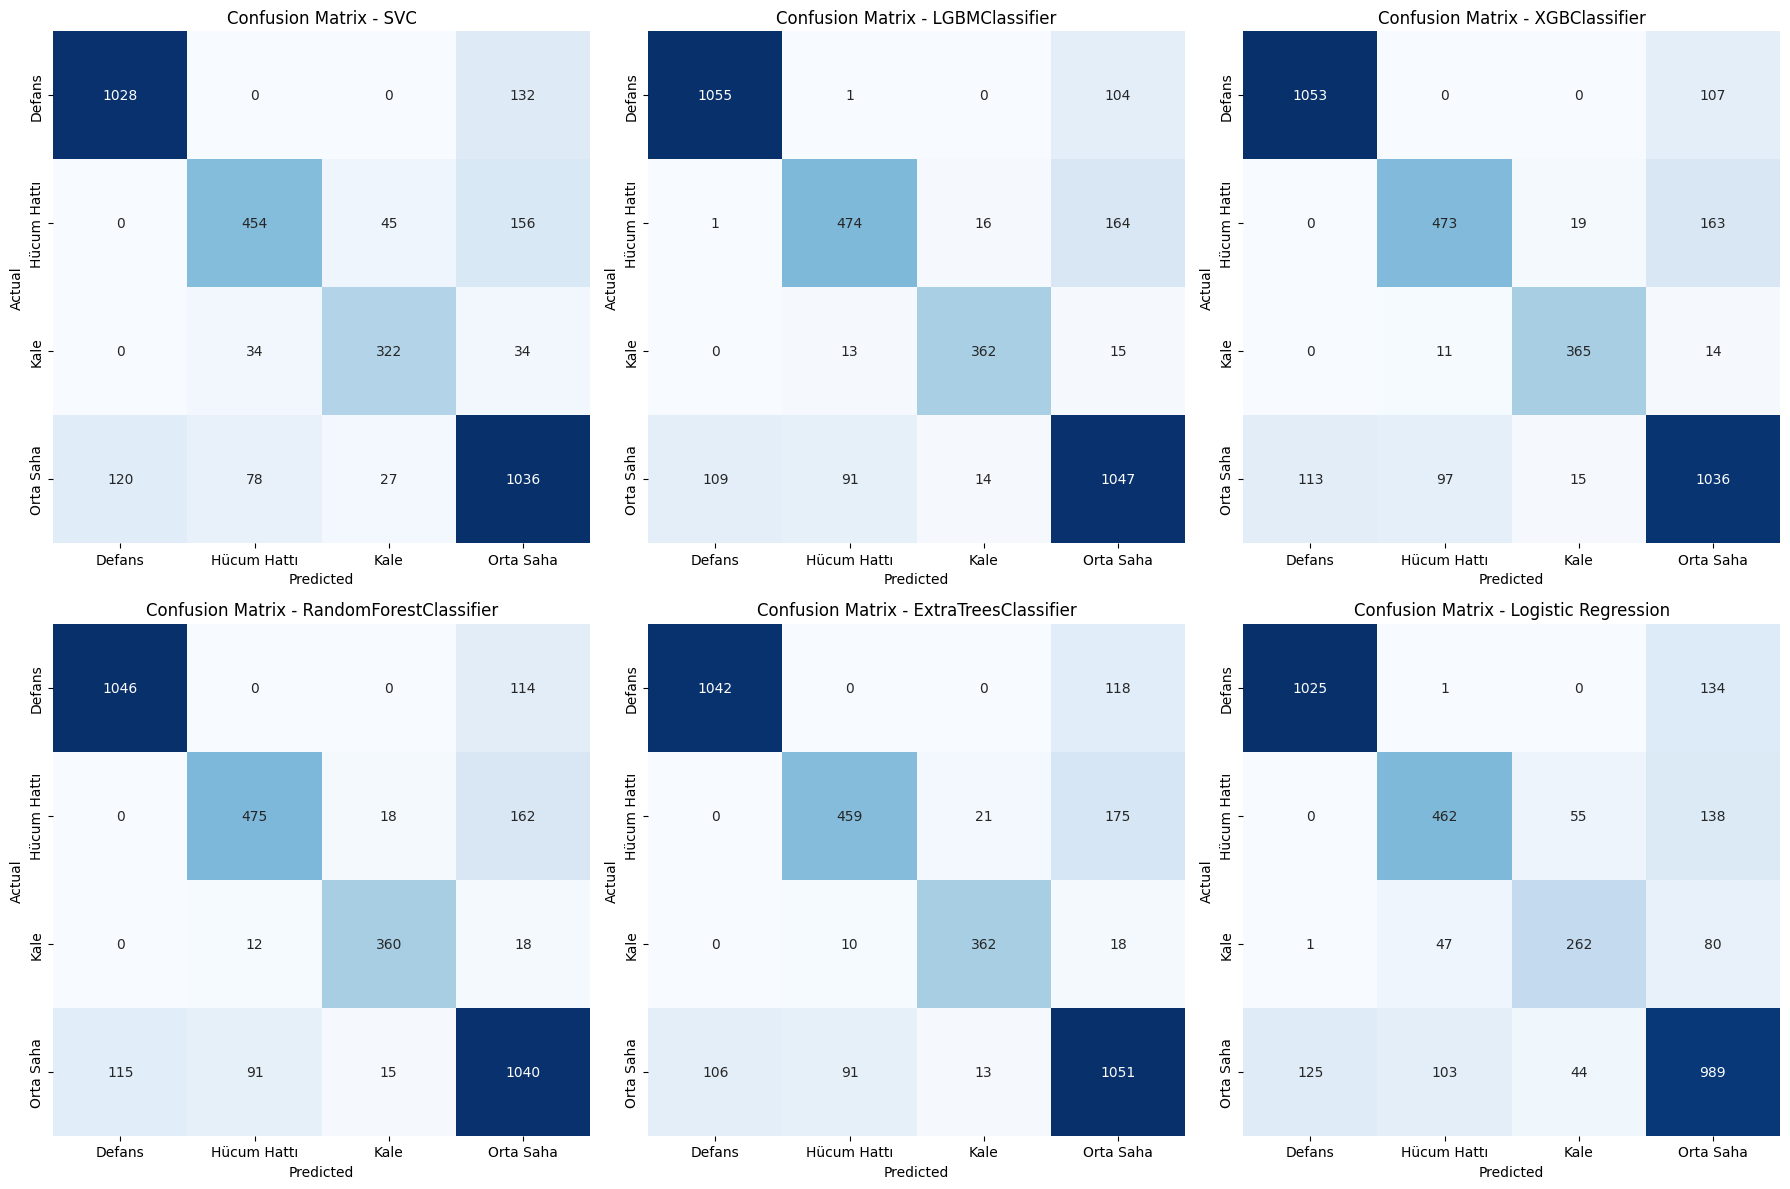

In [37]:
# Modelleri oluşturun ve eğitin
models = {
    "SVC": SVC(),
    "LGBMClassifier": LGBMClassifier(),
    "XGBClassifier": XGBClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "ExtraTreesClassifier": ExtraTreesClassifier(),
    "Logistic Regression": LogisticRegression()
}

for model_name, model in models.items():
    model.fit(X_train, y_train)

# Her bir model için confusion matrix oluşturun
confusion_matrices = {model_name: confusion_matrix(y_test, model.predict(X_test)) for model_name, model in models.items()}

# Matrisleri görselleştirme
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for (model_name, cm), ax in zip(confusion_matrices.items(), axes.flatten()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_title(f"Confusion Matrix - {model_name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

!pip install mlxtend

!pip install imblearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter
from mlxtend.plotting import plot_decision_regions

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

svc_multi_ros = SVC().fit(X_resampled.iloc[:, :2], y_resampled)
plot_decision_regions(X_resampled.iloc[:, :2].values, y_resampled.values, svc_multi_ros)
plt.title(f' Oversampled SVC with y = {Counter(y_resampled)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
